In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import cobra
import scipy

# Yeast

In [9]:
exometabolites_folder = Path("../../data/yeast/")
organism = 'yeast'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [10]:
gDW_per_OD = np.mean([0.644, 0.848])

In [11]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'yeast')

In [83]:
concentrations['ACN']

Time
0       NaN
1     0.000
2     0.000
3     0.000
4     0.000
5     0.000
6     0.021
7     0.095
8     0.079
9     0.138
10    0.322
11    0.411
12    0.527
13    0.683
14    0.765
15    1.161
16    1.187
17    1.236
26    1.652
Name: ACN, dtype: float64

## Remove outliers

In [12]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())


,OD mean,OD std
Time,,
0,0.790,0.174697
1,0.807,0.174697
2,1.170,0.098995
3,1.950,0.084853
4,3.000,0.127279
5,4.675,0.077782
6,6.805,0.049497
7,7.010,0.197990
8,6.750,0.608112


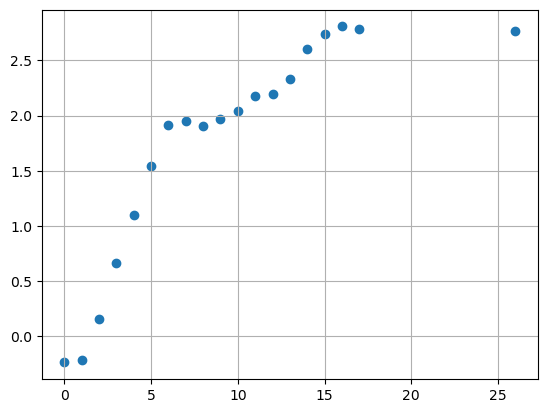

In [13]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

# Estimate max glucose uptake rate
Answer = 8.4 mmol/gDW/h

In [14]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [15]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [16]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

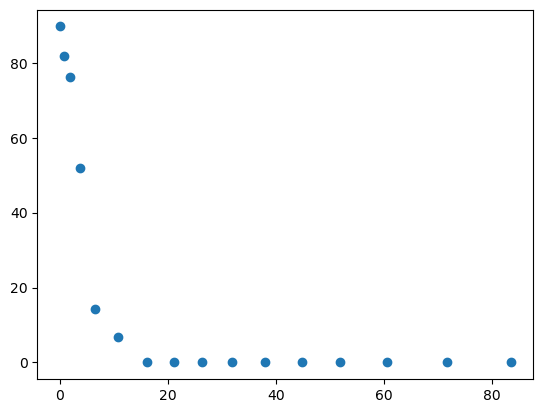

In [17]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [18]:
df_OD.loc[1:6, 'Cum OD gDW']

Time
1     0.000000
2     0.737421
3     1.849334
4     3.704822
5     6.480751
6    10.782497
Name: Cum OD gDW, dtype: float64

In [19]:
np.polyfit(df_OD.loc[1:6, 'Cum OD gDW'], df_glucose.loc[1:6, 'Glucose mM'], 1)

array([-8.37341955, 86.28565969])

## Mapping

In [20]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Yeast metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

## Simpson integration

In [21]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.807 0.595681
2 1.17 1.2900826666666667
3 1.95 2.4494288333333336
4 3.0 4.266622666666667
5 4.675 7.102914666666666
6 6.805 11.354866
7 7.01 16.62933466666667
8 6.75 21.698155999999997
9 7.15 26.934392166666672
10 7.74 32.41320266666666
11 8.86 38.635402166666665
12 9.025 45.394845999999994
13 10.265 52.494217166666665
14 13.53 61.21377599999999
15 15.47 72.14323549999997
16 16.57 84.086136
17 16.23 96.4702955


In [27]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])
x

Time
0      0.000000
1      0.595681
2      1.290083
3      2.449429
4      4.266623
5      7.102915
6     11.354866
7     16.629335
8     21.698156
9     26.934392
10    32.413203
11    38.635402
12    45.394846
13    52.494217
14    61.213776
15    72.143235
16    84.086136
17    96.470296
dtype: float64

Text(0, 0.5, 'Cumulative gDW')

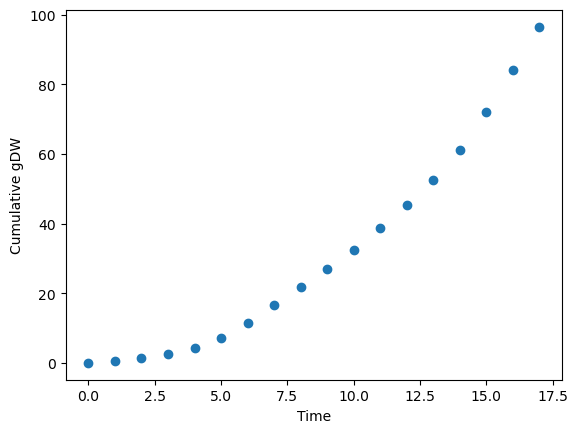

In [88]:
plt.scatter(df_OD.index[:-1], x)
plt.xlabel('Time')
plt.ylabel('Cumulative gDW')

# Fit with custom limits

In [116]:
specific_limits = {
'G6P': (4,6),
'F6P': (1,6),
'FBP': (1,6),
'DHAP': (1,6),
'23PG': (4,6),
'PEP': (1,6),
'RU5P+X5P': (1,6),
'CIT': (3,6),
'ACN': (4,6),
'ICIT': (1,6),
'SUC': (1,5),
'ASN': (1,6),
'GLU': (1,6),
'SER': (1,6),
'ASP': (1,6),
'GLN': (1,4),
'TYR': (1,6),
'PRO': (1,5),
'ALA': (1,6),
'MET': (1,6),
'VAL': (1,5),
'PHE': (1,5),
'LEU+ILEU': (1,6),
'HIS': (1,6),
'LYS': (1,4),
'ARG': (1,6),
'PYR': (1,6),
'ORO': (1,6),
'FUM': (2,6),
'URA': (1,6),
'AKG': (1,6),
'SHI': (1,6),
'ACT': (1,6),
'ETH': (1,6)}

R-squared: 0.849093
R-squared: 0.960077
R-squared: 0.687463
R-squared: 0.964164
23PG One or zero non-zero values in expo. phase
PEP One or zero non-zero values in expo. phase
RU5P+X5P One or zero non-zero values in expo. phase
R-squared: 0.967015
ACN One or zero non-zero values in expo. phase
ICIT One or zero non-zero values in expo. phase
R-squared: 0.937828
R-squared: 0.842799
R-squared: 0.365366
R-squared: 0.661736
R-squared: 0.717503
R-squared: 0.757300
R-squared: 0.540370
R-squared: 0.985534
R-squared: 0.218878
R-squared: 0.289888
R-squared: 0.746188
R-squared: 0.633281
R-squared: 0.049763
HIS More than 1 zero
R-squared: 0.451566
R-squared: 0.612333
ARG More than 1 zero
R-squared: 0.049568
R-squared: 0.923843
R-squared: 0.796424
FUM More than 1 zero
R-squared: 0.955614
R-squared: 0.037693
R-squared: 0.628962
SHI One or zero non-zero values in expo. phase
R-squared: 0.952888
R-squared: 0.992950


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_31853/4200547228.py:60: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, y_max)


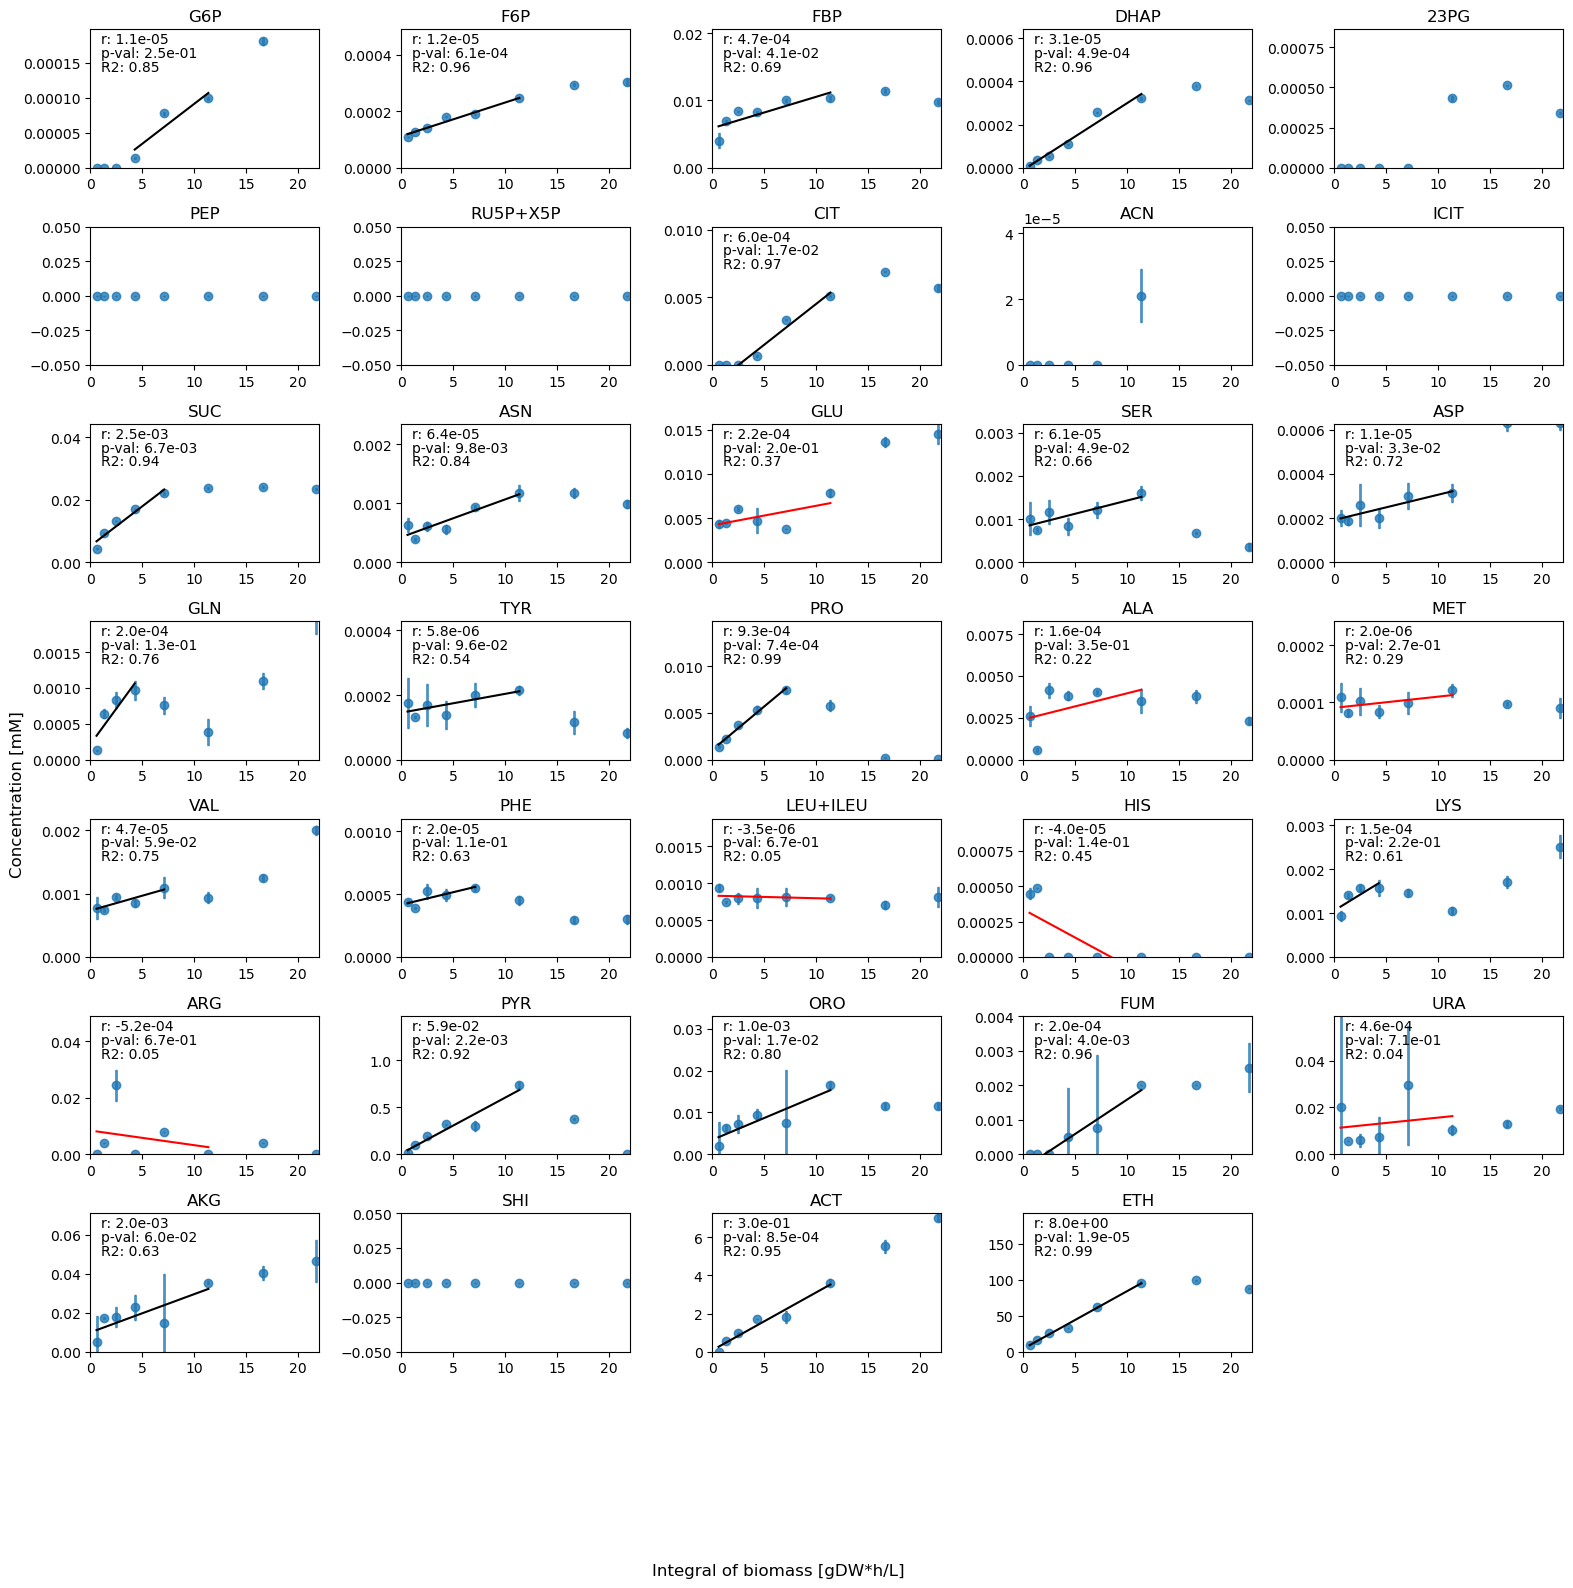

In [134]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
for i,c in enumerate(concentrations.columns):
    # print(c)
    plot_fit = True
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if np.sum(rate_conc == 0) > 1:
        if np.sum(rate_conc == 0) >= len(rate_conc)-1:
            print(c, 'One or zero non-zero values in expo. phase')
            plot_fit = False
        else:
            print(c, 'More than 1 zero')
    # conc[conc==0] = np.nan
    # fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[idx],
    #                                            conc[idx], full_output=True)

    # rate = fit[0]
    # std_err = np.sqrt(np.diag(cov))[0]
    # t_score = fit[0]/std_err
    # n_df = np.sum(idx)-2
 
    # p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
    if plot_fit:
        res = scipy.stats.linregress(x[idx], conc[idx])
        print(f"R-squared: {res.rvalue**2:.6f}")
        r2 = res.rvalue**2
        data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
        data_list.append(data)
        x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
        y_fit = fun(x_fit, res.slope, res.intercept)
    # rate_dict_m[c] = fit[0]
    # print(fit)
    
    ax = axes[i]
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha= 0.8)

    # ax.scatter(x, conc)
    # ax.scatter(x, conc)
    y_max = np.max(conc[idx])*2#[idx]

    if plot_fit:
        if r2 > 0.5:
            ax.plot(x_fit, y_fit, 'k')
        else:
            ax.plot(x_fit, y_fit, 'r')
            
        ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
        ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
        ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
        
    ax.set_title(c)
    ax.set_xlim(0, 22)
    ax.set_ylim(0, y_max)

    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('yeast_fitted_rates_manual_limits.png', dpi = 400)
plt.show()

In [127]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

ValueError: operands could not be broadcast together with shapes (19,) (18,) 

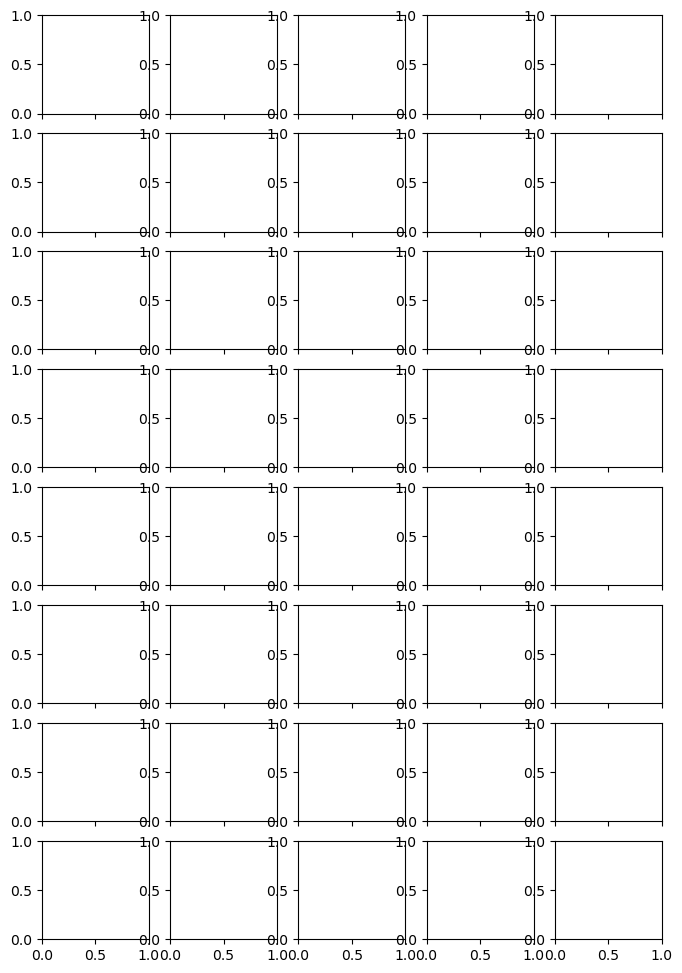

In [119]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (8, 12), sharex = True)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
for i,c in enumerate(concentrations.columns):
    conc = concentrations[c]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index < 7
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
    # print(c)
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (5 in rate_conc.index) and (6 in rate_conc.index):
        if rate_conc[6] < rate_conc[5]:
            selection[6] = False
            if rate_conc[5] < rate_conc[4]:
                selection[5] = False
                
    if len(conc[nan_idx&time_idx]) >1:
        fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                                   conc[nan_idx&time_idx&selection],
                                                   full_output=True)
        rate_dict[c] = fit[0]
    else:
        rate_dict[c] = np.nan

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.show()


In [89]:
rate_dict

{'G6P': 9.505568649051493e-06,
 'F6P': 9.776019161656112e-06,
 'FBP': 0.0003849188745723047,
 'DHAP': 2.5388744950441975e-05,
 '23PG': 3.13874063821448e-05,
 'PEP': nan,
 'RU5P+X5P': nan,
 'CIT': 0.0005070427999871657,
 'ACN': 1.5293167842808376e-06,
 'ICIT': nan,
 'SUC': 0.0014004072376727955,
 'ASN': 5.240153757831557e-05,
 'GLU': 0.000179635296962267,
 'SER': 5.0027519304184284e-05,
 'ASP': 9.373626013763747e-06,
 'GLN': 0.00016012174645632632,
 'TYR': 4.767734782025762e-06,
 'PRO': 0.000751229710159897,
 'ALA': 0.0002903059079740295,
 'MET': 1.5894993555322214e-06,
 'VAL': 3.783146801141533e-05,
 'PHE': 1.6179910033258154e-05,
 'LEU+ILEU': -5.2565022909659005e-06,
 'HIS': 4.697417566050269e-05,
 'LYS': 0.00011741546162016314,
 'ARG': -0.0006934404797695197,
 'PYR': 0.04856333656350536,
 'ORO': 0.0008533902343530742,
 'FUM': 0.00018030281748730893,
 'URA': 0.0017656684027500594,
 'AKG': 0.0016078137831463623,
 'SHI': nan,
 'ACT': 0.23391714567973793,
 'ETH': 6.553645389120347}

# Get model

## Functions

In [120]:


def print_summary_r(model, solution):
    # Print uptake
    for r_id in model.get_exchange_reactions():
        flux = solution.values[r_id]
        r = model.reactions[r_id]
        if  flux >1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
        elif flux < -1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution.values['R_r_2111'])
    print("Prot pool exchange: ", solution.values['R_prot_pool_exchange'])

In [121]:
model_ez = reframed.load_cbmodel('../../models/yeast/ecYeastGEM_batch_8_3_4_no_rev_ex.xml')
model_ez.solver = 'gurobi'

In [122]:
solution = reframed.FBA(model_ez, constraints={'R_r_1714':(-8.4, 0)})
print_summary_r(model_ez, solution)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19
R_r_1634 acetate exchange 3.075754792010952 0.0 inf
R_r_1654 ammonium exchange -2.43303437664508 -inf inf
R_r_1672 carbon dioxide exchange 9.11634304717526 0.0 inf
R_r_1714 D-glucose exchange -8.4 -inf 0.0
R_r_1761 ethanol exchange 4.18408458921098 0.0 inf
R_r_1793 formate exchange 0.015220715199668814 0.0 inf
R_r_1832 H+ exchange -0.33105925084136034 -inf inf
R_r_1992 oxygen exchange -6.284051298123278 -inf 0.0
R_r_2005 phosphate exchange -0.09711569323307018 -inf inf
R_r_2020 potassium exchange -0.0012891476190273923 -inf inf
R_r_2033 pyruvate exchange 4.063716832668875 0.0 inf
R_r_2049 sodium exchange -0.0014098942279721065 -inf inf
R_r_2060 sulphate exchange -0.032510562780153685 -inf inf
R_r_2100 water exchange 15.399401351907832 -inf inf
R_r_2111 growth 0.35513708513151304 0.0 inf
R_prot_pool_exchange prot_pool_exchange 0.103720024310123 0.0 0.103720024310123
Growth:  0.35513708513151304
Pr

# Mapping

In [123]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)


In [124]:
measured_metabolites = []
for value in met_abrv_to_id.values():
    if not isinstance(value, str):
        continue
    bigg_ids = value.split(', ')
    for bigg_id in bigg_ids:
        m_id = f'M_{bigg_id}__91__c__93__'
        if m_id in model_ez.metabolites:
            measured_metabolites.append(m_id)

# Turnover

In [125]:
solution = reframed.pFBA(model_ez, constraints={'R_r_1714':(-7.4, 0)})
turnover = solution.get_metabolites_turnover(model_ez)

# Shadow prices

In [126]:
if len(measured_metabolites):
    shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_r_1714':(-3, 0)},
                                                        metabolites = measured_metabolites)

# Make spreadsheet

In [129]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The L-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}__91__c__93__'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([abbr, bigg_id, name, mv, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

In [130]:
# data = []
# for abbr, rate in rate_dict.items():
#     bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
#     rate = rate/len(bigg_ids)
#     for bigg_id in bigg_ids:
#         name =met_abrv_to_name[abbr]
#         m_id = f'M_{bigg_id}__91__c__93__'
#         mv = -shadow_prices[m_id]
#         m = model_ez.metabolites[m_id]
#         element_dict = ng_utils.get_element_dict(m)
#         Nc = element_dict['C']
#         mass = ng_utils.get_mol_weight(m)
#         model_met_name = m.name.replace('[cytoplasm]','')
#         data.append([bigg_id, name, model_met_name, rate, mv, turnover[m_id], Nc, mass])
# df_rate = pd.DataFrame(data, columns = ['Yeast ID', 'Metabolite', 'Model metabolite name', 'Rate [mmol/gDW/h]', 
#                                         'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
#                                         'Mol weight [g/mol]'])

In [136]:
df_rate['Species'] = 'S. cerevisiae'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [137]:
df_rate.to_csv('paczia_13_rates_yeast_130524.csv')

In [132]:
df_rate

,Metabolite abbrv.,BiGG ID,Metabolite,Metabolite value [gDW/mmol],Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std.Err [mmol/gDW/h],R2
0,G6P,s_0568,Glucose-6-phosphate,0.094507,7.400000,6,260.135781,0.000011,0.000005,0.849093
1,F6P,s_0557,Fructose-6-phosphate,0.094507,6.692192,6,258.119901,0.000012,0.000001,0.960077
2,FBP,s_0555,"Fructose-1,6-bisphosphate",0.098844,0.000000,6,340.115682,0.000468,0.000158,0.687463
3,DHAP,s_0629,Dihydroxyacetonephosphate,0.049422,6.463743,3,168.041961,0.000031,0.000003,0.964164
4,CIT,s_0522,Citrate,0.070808,0.118104,6,189.099700,0.000603,0.000079,0.967015
5,SUC,s_1458,Succinate,0.050576,0.062829,4,116.072160,0.002548,0.000379,0.937828
6,ASN,s_0969,Asparagine,0.058674,0.044616,4,132.117920,0.000064,0.000014,0.842799
7,SER,s_1039,L-serine,0.041619,0.285087,3,105.092580,0.000061,0.000022,0.661736
8,ASP,s_0973,Aspartate,0.047109,0.558052,4,132.094740,0.000011,0.000004,0.717503
9,GLN,s_0999,Glutamine,0.075145,0.333573,5,146.144500,0.000199,0.000080,0.757300
